In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

import sys
sys.path.append('..')

import neural_manifolds as nm

%load_ext autoreload
%autoreload 2

# Example: spikes with 2D latent model
Here, we construct spikes for $N$ neurons from time-dependent rates $\nu_i(t)$ that are linear combinations from a latend model with $z(t)$

Specifically, we choose 
$$
   z_1(t) = sin(\pi \omega t)\\
   z_2(t) = cos(\pi \omega t )
$$

(2, 100000)
{'model': <function _latent_sin_cos_model at 0x12b5fb880>,
 'model_kwargs': {'omega': 0.2},
 'type': 'sin_cos'}


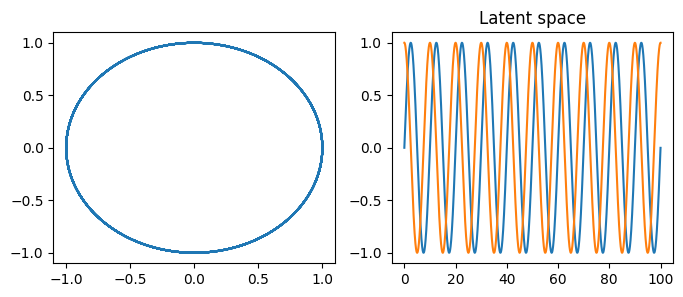

In [2]:
latent_model = nm.test_data.LatentModel("sin_cos", omega=0.2)

t = np.arange(0,100,0.001)
latent_state = latent_model(t)
print(latent_state.shape)
f, axes = plt.subplots(1,2,figsize=((8,3)))
axes[0].plot(latent_state[0,:],latent_state[1,:])
axes[1].plot(t,latent_state[0,:])
axes[1].plot(t,latent_state[1,:])

plt.title("Latent space")
print(latent_model)

Then, we generate neural firing rates as linear combinations of the latent variables

$$
  \nu_i (t) = c_1*z_1(t) + c_2*z_2(t) + offset
$$

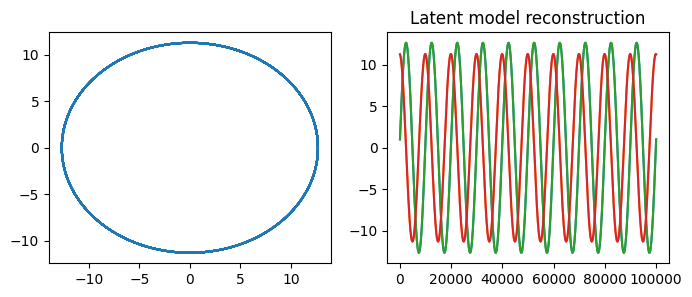

In [3]:
from neural_manifolds.test_data import firing_rates
# Number of neurons
N = 32
rates = firing_rates(latent_model, t, N)
pca_rates = PCA()
pca_rates.fit(rates.T)

# Projection on largest two principal components:
signal_low_dim = pca_rates.transform(rates.T)[:,:2]
f, axes = plt.subplots(1,2,figsize=((8,3)))
axes[0].plot(signal_low_dim[:,0],signal_low_dim[:,1])
axes[1].plot(signal_low_dim)

plt.title("Latent model reconstruction")
plt.plot(signal_low_dim)
plt.show()

To get a bit more realistic, let's generate actual spikes as an inhomogeneous poisson process

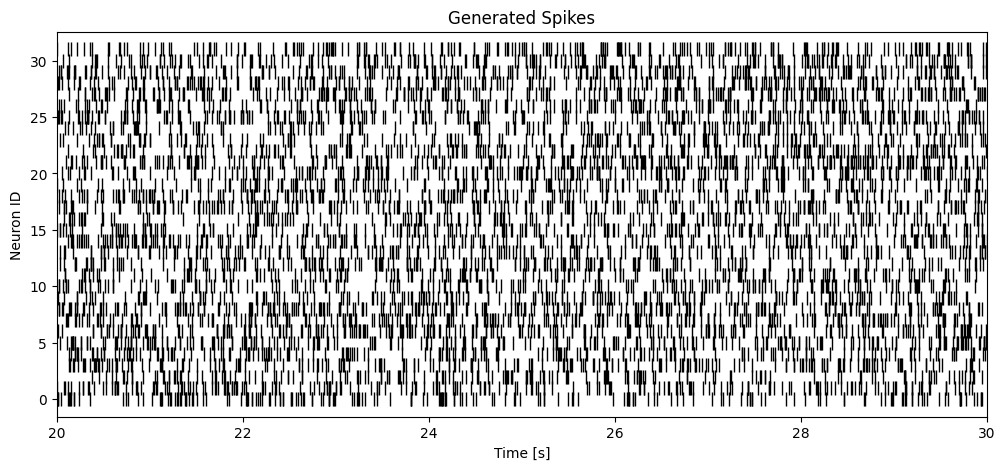

In [5]:

spikes = nm.test_data.inhomogenous_poisson_spikes(dict(times=t,rates=rates))

ids = np.unique(spikes[:,0])

fig, ax = plt.subplots(1,1,figsize=(12, 5))
for id in ids:
    mask = spikes[:,0] == id
    spike_times = spikes[mask,1]
    ax.plot(spike_times, np.ones_like(spike_times)*id, '|', color='k', markersize=10)

ax.set_xlabel('Time [s]')
ax.set_ylabel("Neuron ID")
ax.set_title("Generated Spikes")
ax.set_xlim(20,30)
plt.show()

Follow analysis of https://www.nature.com/articles/s41593-019-0555-4

Bin spikes in windows of size 30ms, take the square root and then blur with a gaussian kernel of 500ms instead of 50ms:

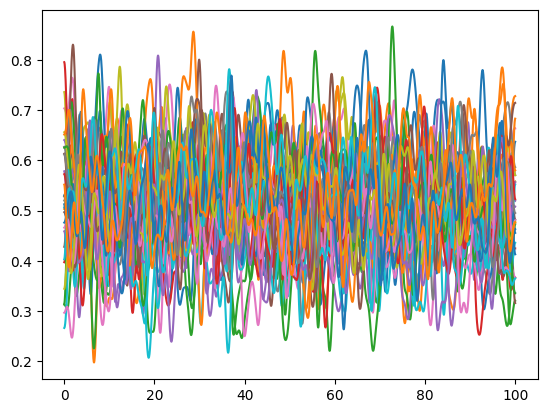

In [6]:
time, signal = nm.test_data.signals.smooth_spikes(spikes, bin_width = 0.03, std_gaussian = 0.5, sampling_width=0.03, sqrt=True)
plt.plot(time, signal.T);

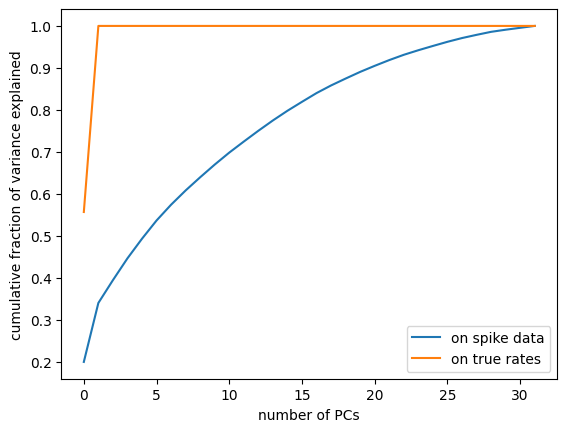

In [7]:
pca = PCA()
# print(signal.shape)
pca.fit(signal.T)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='on spike data')
plt.plot(np.cumsum(pca_rates.explained_variance_ratio_), label='on true rates')
plt.xlabel('number of PCs')
plt.ylabel('cumulative fraction of variance explained')
plt.legend()

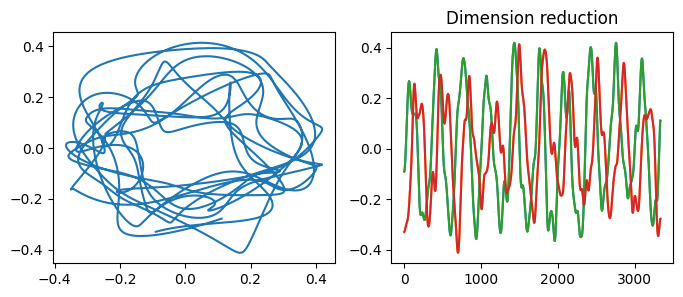

In [8]:
# Projection on largest two principal components:
signal_low_dim = pca.transform(signal.T)[:,:2]
f, axes = plt.subplots(1,2,figsize=((8,3)))
axes[0].plot(signal_low_dim[:,0],signal_low_dim[:,1])
axes[1].plot(signal_low_dim)

plt.title("Dimension reduction")
plt.plot(signal_low_dim)
plt.show()

Comparison between different input stream sizes

In [53]:
def fit_pca(times,rates):
    rates_object = dict(times=t, rates=rates)
    spikes = nm.test_data.inhomogenous_poisson_spikes(rates_object)
    _, signal = nm.test_data.signals.smooth_spikes(spikes, bin_width = 0.03, std_gaussian = 0.5, sampling_width=0.03, sqrt=True)
    signal_train = signal[:,:signal.shape[1]//4*4]
    signal_test = signal[:,signal.shape[1]//4:]
    pca = PCA()
    pca.fit(signal_train.T)
    return pca, signal_test

pcas=dict()
signals=dict()

for N in [10,50,100]:
    pca, signal = fit_pca(t,firing_rates(latent_model, t, N))
    pcas[f"{N}"]   = pca
    signals[f"{N}"] = signal
    print(signal.shape)


(10, 2500)
(50, 2501)
(100, 2501)


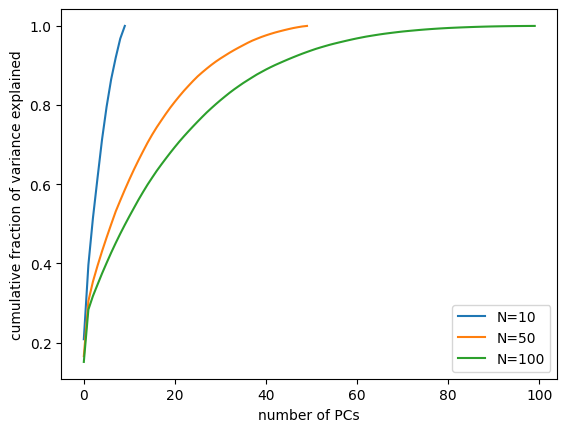

In [54]:
for key in pcas.keys():
    N = int(key)
    y = np.cumsum(pcas[key].explained_variance_ratio_)
    x = np.arange(len(y))
    plt.plot(x,y, label=f'N={key}')
plt.xlabel('number of PCs')
plt.ylabel('cumulative fraction of variance explained')
plt.legend()

But interestingly, considering only the first two PCs the low-dimensional representation becomes better for larger signals 

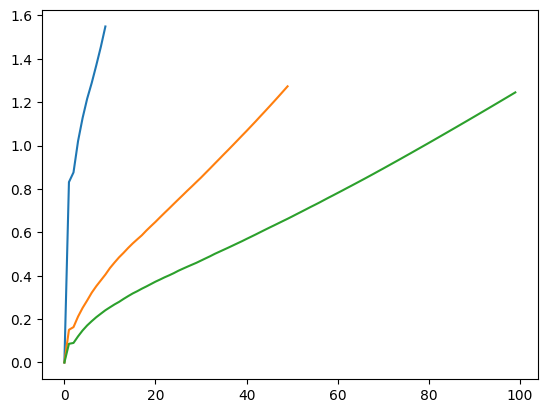

In [67]:
for (i,key) in enumerate(pcas.keys()):
    signal_transform = pcas[key].transform(signals[key].T)
    data = signal_transform - np.mean(signal_transform)
    # calculate how much of original variance of signal is still in transformation
    variance_explained = np.zeros(data.shape[1])
    var_total = np.var(signals[key].T)
    for i in np.arange(1,data.shape[1]):
        variance_explained[i] = var_total/np.var(data[:,:i])
    plt.plot(variance_explained, label=f"N{key}")
plt.show()
    

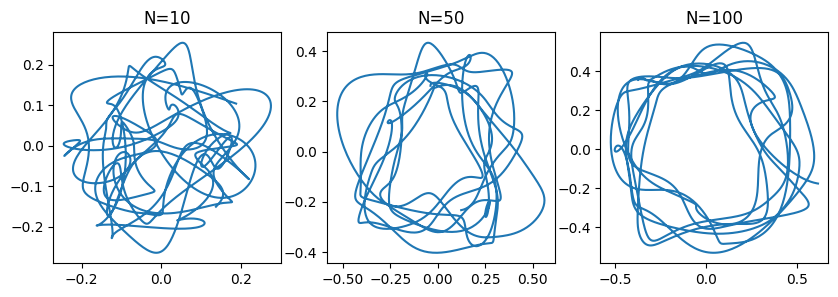

In [55]:
f, axes = plt.subplots(1,3,figsize=((10,3)))
for (i,key) in enumerate(pcas.keys()):
    signal_low_dim = pcas[key].transform(signals[key].T)[:,:2]
    axes[i].plot(signal_low_dim[:,0],signal_low_dim[:,1], label=f"N={key}")
    axes[i].title.set_text(f"N={key}")

plt.show()